In [20]:
import os
import json
import pickle
import random
import copy
import datasets
from PIL import Image, ImageDraw
import numpy as np

import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"

In [2]:
# import nltk
# try:
#     nltk.data.find("tokenizers/punkt")
# except (LookupError, OSError):
#     nltk.download("punkt", quiet=True)

In [3]:
# uses common functions and not the ones declared in the beginning
# TODO: use only functions from library (vit_captioning_analysis) to avoid confusion
from vit_captioning_analysis import VITCaptioningModel
from vit_captioning_analysis import order_obj_instances

model = VITCaptioningModel(output_encoder_attentions=True, output_encoder_hidden_states=True)

model running on cuda


/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
# model.config

## Sanity check

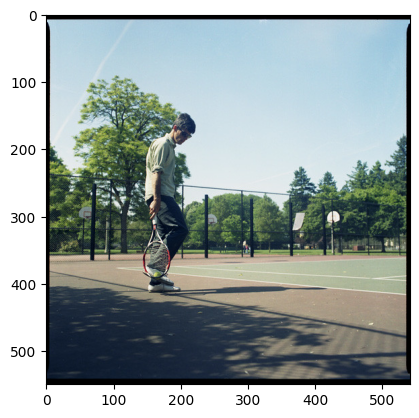

In [5]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [6]:
outputs = model.forward_pass(sample_image)

In [7]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

In [8]:
len(outputs.encoder_attentions)

12

In [9]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 197, 197])

In [10]:
len(outputs.encoder_hidden_states)

13

In [11]:
outputs.encoder_hidden_states[0].shape

torch.Size([1, 197, 768])

### Segmentation selection

From the filtered dataset, figure out which **instance** of the object will be used to create the object mask and select tokens.

This is required since objects have 1:N instances and some of them can be considered *background*, therefore tokens from these areas should not be considered.

**Options:**
* Object 1: 
    * biggest object in MAIN class
    * merge all masks of MAIN class into one
    * attention map based
* Object 2 
    * biggest object in SECONDARY class
    * merge all masks of SECONDARY class into one
    * closest mask to MAIN object
    * attention based
* ...

In [12]:
COCO_PATH = "../../../datasets/coco"

In [13]:
with open("../task1_person_accessory_data.json", "r") as f:
    person_annotations = json.load(f)
    
# with open("../task1_person_accessory_data_w_caption.json", "r") as f:
#     person_annotations = json.load(f)    

with open("../task2_dining_objects_data.json", "r") as f:
    dining_obj_annotations = json.load(f)    

In [21]:
with open('../coco_category_id_map.pickle', 'rb') as handle:
    category_id_map = pickle.load(handle) 

In [14]:
person_annotations.keys()

dict_keys(['27', '28', '31', '32', '33'])

In [15]:
dining_obj_annotations.keys()

dict_keys(['44', '47', '48', '49', '51', '62'])

In [16]:

# TODO: 
# * get secondary object based on proximity - closest object
# * limit objects closer to the main cluster of activation
#   or choose the main object from area in main cluster of activation 
def get_bbox_center(annotation):
     return np.array((annotation["bbox"][0] + int(annotation["bbox"][2]/2), 
             annotation["bbox"][1] + int(annotation["bbox"][3]/2)))

def get_largest_mask(annotation, obj, img_draw):
    # select main (largest) mask for the object class        
    objects_area = [(ann['id'], ann['area']) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj and ann['iscrowd']==0]
    largest_obj = sorted(objects_area, key=lambda x: x[1], reverse=True)[0]
    largest_obj_ann = [ann for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj[0]]
    largest_obj_ann = largest_obj_ann[0] #avoid more than one object with same area
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj_ann["id"]]
    for segment in segmentation[0]:
        try:
            img_draw.polygon(segment, fill ="#ffffff")
        except ValueError:
            return None
    return [largest_obj_ann]
    
def get_all_masks(annotation, obj, img_draw):
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
    for segment in segmentation:
        if isinstance(segment, list):
            try:
                img_draw.polygon(segment[0], fill ="#ffffff")
            except ValueError:
                return None
    return None

def get_mask_with_attention(img, annotation, category_id, img_draw, layer_attention_maps):
    segm_with_att = order_obj_instances(img, category_id, annotation, layer_attention_maps)
    for segment in segm_with_att[0][0]['segmentation']:
        img_draw.polygon(segment, fill ="#ffffff")
    return segm_with_att[0]

def get_objects_mask(annotation, objects=[], option=1, attention_maps=None):
    sample_image = Image.open(os.path.join(COCO_PATH, 'train2017', annotation['image']['file_name'])).convert('RGB')    
    masks = []
    for idx, obj in enumerate(objects):
        pil_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
        pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
        img_draw = ImageDraw.Draw(pil_mask) 
        
        if option == 1:
            get_largest_mask(annotation, obj, img_draw)

        # merge all masks of the object class into one
        elif option == 2:
            get_all_masks(annotation, obj, img_draw)    
                    
        # get closest mask based on a reference mask (first object)
        # calculate the centroid and then find the other mask closest to this centroid
        # using euclidian distance
        elif option == 3:
            ## assume first object is the reference. Get the first object based on biggest mask
            if idx==0:
                ref_annotation = get_largest_mask(annotation, obj, img_draw)[0]
            else:
                ref_center = get_bbox_center(ref_annotation)
                distances = [(np.linalg.norm(ref_center - get_bbox_center(ann)), ann["id"]) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
                closest_obj = distances[0]
                segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==closest_obj[1]]
                for segment in segmentation[0]:
                    try:
                        img_draw.polygon(segment, fill ="#ffffff")
                    except ValueError:
                        return None
        
        elif option == 4:
            # this option produces 12 masks, one for each layer of the transformers encoder
            pil_mask = []
            for layer in range(12):
                att_layer_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
                att_layer_mask = Image.fromarray(np.moveaxis(att_layer_mask, 0, -1))
                img_draw = ImageDraw.Draw(att_layer_mask) 
                get_mask_with_attention(sample_image, 
                                        annotation, 
                                        obj, 
                                        img_draw, 
                                        attention_maps[layer][0, 1:].cpu().detach().numpy())
                pil_mask.append(att_layer_mask)
        
        masks.append(pil_mask)        
        
    return masks

In [17]:
## 

## Test different strategies for selecting segmentation 
Which instance of the object to choose:
1. Biggest segmentation mask
2. Merge all segmentation masks into one (joint segmentation mask)
3. Closest mask based on a reference mask (first object)
4. Attention based (instance that gets **maximum attention**)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


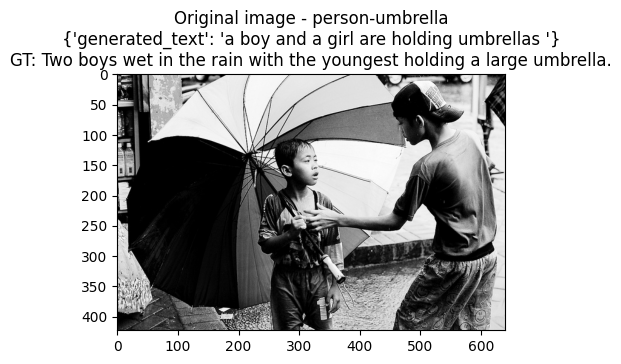

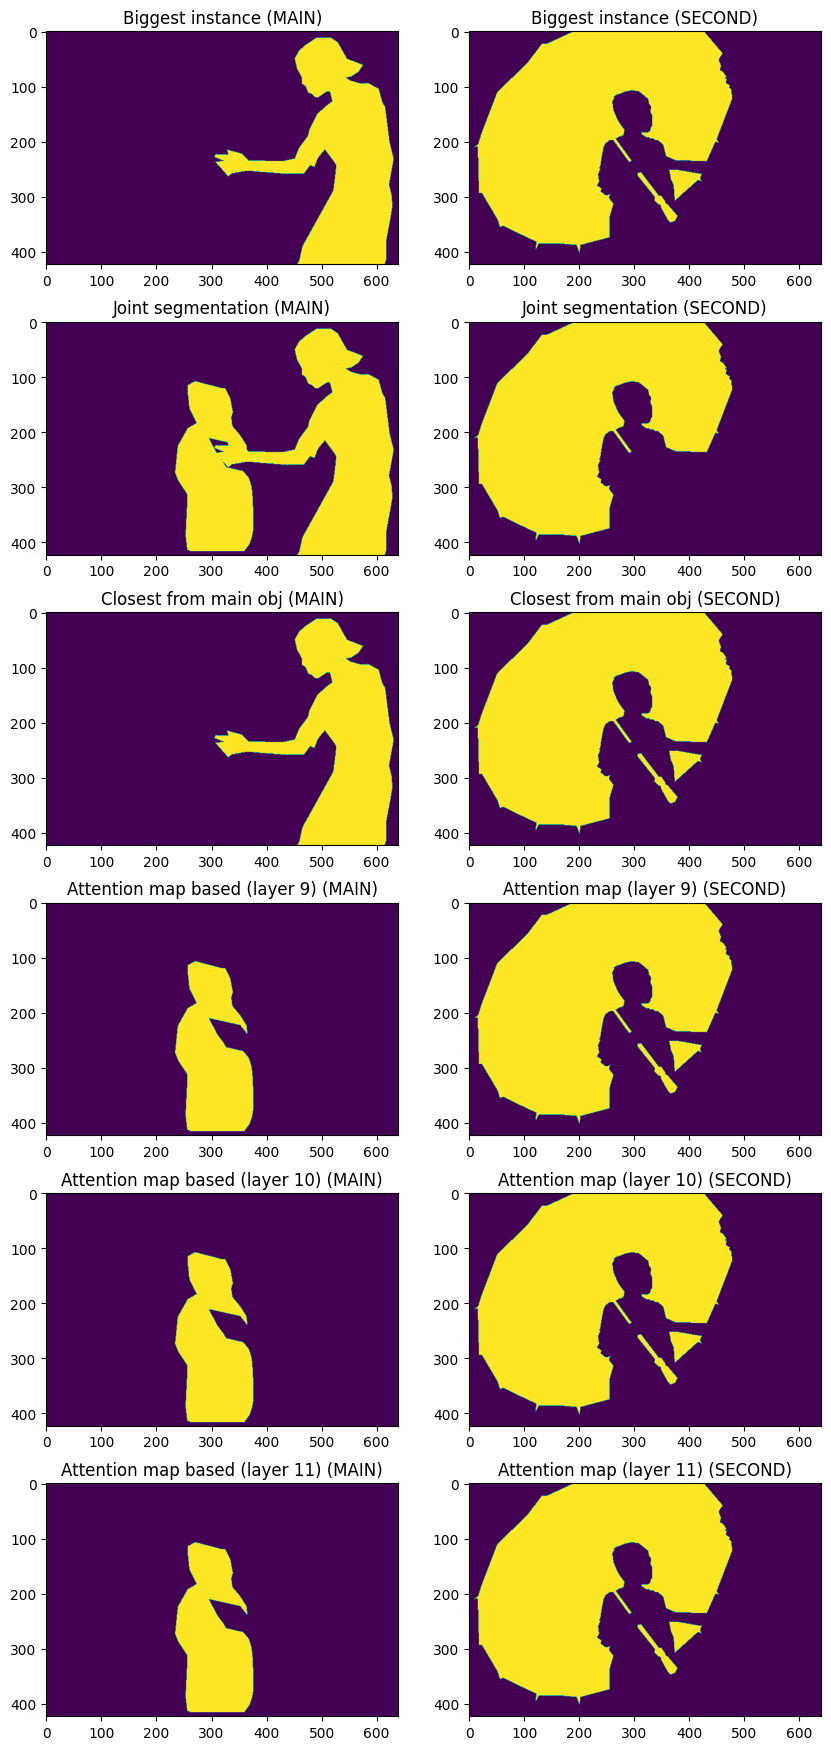

In [73]:
main_obj = 1
second_obj = 28

sample_ann = person_annotations[str(second_obj)][6]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    

sample_caption = model.generate_caption(sample_img)[0]

plt.figure(figsize=(5,6))
plt.title(f"Original image - {category_id_map[main_obj]}-{category_id_map[second_obj]}\n{sample_caption}\nGT: {sample_ann['annotations']['caption']}")
plt.imshow(sample_img)
plt.show()

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 22))
    
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=1)
axs[0, 0].set_title("Biggest instance (MAIN)")
axs[0, 0].imshow(masks[0])
axs[0, 1].set_title("Biggest instance (SECOND)")
axs[0, 1].imshow(masks[1])

masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=2)
axs[1, 0].set_title("Joint segmentation (MAIN)")
axs[1, 0].imshow(masks[0])
axs[1, 1].set_title("Joint segmentation (SECOND)")
axs[1, 1].imshow(masks[1])
    
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=3)
axs[2, 0].set_title("Closest from main obj (MAIN)")
axs[2, 0].imshow(masks[0])
axs[2, 1].set_title("Closest from main obj (SECOND)")
axs[2, 1].imshow(masks[1])

outputs = model.forward_pass(sample_img)
sample_attention_map = model.get_all_attention_maps(outputs.encoder_attentions)
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=4, attention_maps=sample_attention_map)
axs_idx = 3
for layer in range(9, 12):
    axs[axs_idx, 0].set_title(f"Attention map based (layer {layer}) (MAIN)")
    axs[axs_idx, 0].imshow(masks[0][layer])
    axs[axs_idx, 1].set_title(f"Attention map (layer {layer}) (SECOND)")
    axs[axs_idx, 1].imshow(masks[1][layer])
    axs_idx += 1

### Questions:
1. in the example above, does selecting a different boy yields the same results?
2. Both "person" object can be decoded as person?

# Relevant token extraction

In [74]:
#grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
grid_size = 14

In [75]:
from vit_captioning_analysis import is_patch_within_mask, find_original_img_patch

### Get tokens:
1. Maximum and minimum attention token in the region for object 1. 
2. Maximum and minimum attention token from object 2. 
3. A Random token each from both objects. 
4. Max token from the whole image
5. The token consistently paid attention in last 3 layers. (from the whole image? or just FG?)

All the tokens are per layer, is it the best way to do?

In [76]:
from vit_captioning_analysis import xy_coord_token, find_mask_tokens

# TODO: Improve logic of consistent tokens to account for different variations of layers and not only the last N
def find_tokens_in_region(attention_map:np.array, 
                          img: np.array, 
                          mask: np.array, 
                          layers=[9,10,11], 
                          min_n=3, 
                          max_n=20,
                          mask_threshold=.75,
                          grid_size=14,
                          display_token_grid=False,
                          display_att_layers=False):
    tokens = {}
    all_top_n = []
    
    if display_token_grid:
        # show original mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask)
        plt.show()
        # set up the plot with 14x14 image patches
        fig, axs = plt.subplots(nrows=14, ncols=14, figsize=(6, 6))
    
    # find which tokens belong to the mask
    mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold)
    # If there are not tokens related to the mask, it is probably
    # because the mask region inside the patch is too small
    # try to find mask tokens again with threshold=0.
    #    e.g.: if one pixel falls into the mask patch it means it is a mask token/patch
    if not mask_tokens:
        mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold=0)
        if not mask_tokens:
            return None, None, None
        
    # for each n_layers in the attention_map
    # find all tokens
    for layer_no in layers: #enumerate(attention_map[n_layers:, :, :]):
        layer = attention_map[layer_no, :, :]
        tokens_layer_i = {}
        
        # MAX token whole image
        tokens_layer_i['max_image'] = np.argmax(layer[0, 1:].cpu().detach().numpy())
        
        # set all background activation WITHIN background mask to -1
        img_att_map_mask = copy.deepcopy(layer[0, 1:].cpu().detach().numpy())
        img_att_map_mask[~mask_patches] = 0
        
        # MIN MAX token within object/mask
        max_token_obj_layer_i = np.argmax(img_att_map_mask)
        # TODO: Improve logic to get min attention token considering only one region. 
        # when slicing np.array and using np.argmin the index returned is not relative to original array anymore
        # e.g.: np.argmin(img_map_fg[fg_mask_patch]) will return an index relative to the new array img_map_fg[fg_mask_patch]
        min_token_obj_layer_i = 0
        min_activation = np.max(img_att_map_mask)
        for token_i in mask_tokens:
            if img_att_map_mask[token_i] < min_activation:
                min_token_obj_layer_i = token_i
                min_activation = img_att_map_mask[token_i]

        tokens_layer_i['max_obj'] = max_token_obj_layer_i
        tokens_layer_i['min_obj'] = min_token_obj_layer_i
        
        # RANDOM token within object
        tokens_layer_i['random_obj'] = random.choice(mask_tokens)
        
        # Get top N activations of the layer
        # based on https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        top_n = np.argpartition(img_att_map_mask, -1 * max_n)[-1 * max_n:]
        top_n = top_n[np.argsort(img_att_map_mask[top_n])]
        top_n = top_n[::-1]
        all_top_n.append(top_n)  
        
        tokens[layer_no] = tokens_layer_i

        # show grid with all tokens found
        if display_token_grid:
            for patch_i, img_patch in enumerate(img_patches):
                row_p, col_p = xy_coord_token(patch_i)
                if mask_patches[patch_i]:
                    axs[col_p, row_p].imshow(img_patch)                       
                else:
                    axs[col_p, row_p].imshow(np.zeros_like(img_patch))
    #                 axs[col_p, row_p].set_title(mask_patches[patch_i])
                axs[col_p, row_p].axis('off')
            plt.show()
            
        if display_att_layers:
            plt.figure(figsize=(3, 3))
#             plt.imshow(layer[0, 1:].cpu().detach().numpy().reshape(grid_size, grid_size))
            plt.imshow(img_att_map_mask.reshape(grid_size, grid_size))
            plt.title(f"layer {layer_no}, shape {img_att_map_mask.shape} ")
            row_p, col_p = xy_coord_token(tokens_layer_i['min_obj'])
            plt.scatter(row_p, col_p, marker='_', c='blue')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_obj'])
            plt.scatter(row_p, col_p, marker='+', c='red')
            row_p, col_p = xy_coord_token(tokens_layer_i['random_obj'])
            plt.scatter(row_p, col_p, marker='*', c='green')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_image'])
            plt.scatter(row_p, col_p, marker='P', c='orange')
            plt.show()
    
    consistent_token = None
#     # FOR CONSISTENT TOKEN ACROSS SEVERAL LAYERS
#     # find if there's intersection with previous layer
#     for n in range(min_n, max_n, 2):
#         common_tokens = set()
#         for layer_no, layer_top_n in enumerate(all_top_n):
#             if layer_no==0:
#                 common_tokens = set(layer_top_n[:n])                
#             else:
#                 common_tokens = common_tokens.intersection(set(layer_top_n[:n]))
#                 if not common_tokens:
# #                     print(f"No common token with top {n}")
#                     break
#         if common_tokens:
# #             print(f"found common tokens with top {n}")
#             consistent_token = list(common_tokens)
#             if len(consistent_token)>1:
#                 # sum selected tokens across all layers to get top 1
#                 sums = dict(zip(consistent_token, [0] * len(consistent_token)))
#                 for layer in attention_map[n_layers:, :, :]:
#                     for token in consistent_token:
#                         sums[token] += layer[0, token].cpu().detach().numpy()
# #                 print(sums)
#                 consistent_token = max(sums, key=sums.get)
# #                 print(consistent_token)
#             else:
#                 consistent_token = consistent_token[0]
#             break    

    return tokens, consistent_token, all_top_n

In [77]:
def extract_tokens(img: Image.Image, mask:np.array, mean_att_map, layers:list, mask_threshold=.75, debug=False):
        
    # some regions of the image have intermediate values between 0 and 255
    # maybe resizing the image create these "intermediate" pixels.
    fg_mask_img = copy.deepcopy(mask)
    fg_mask_img[fg_mask_img==255] = 255
    fg_mask_img[fg_mask_img!=255] = 0
    fg_mask_img = fg_mask_img[:,:,np.newaxis]
    # get background mask by reversing the image mask
    bg_mask_img = copy.deepcopy(fg_mask_img)
    bg_mask_img[fg_mask_img==255] = 0
    bg_mask_img[fg_mask_img!=255] = 255
    
## Not using background tokens at the moment
#     bg_tokens, consistent_bg_token, _ = find_tokens_in_region(mean_att_map, np.array(img), bg_mask_img, mask_threshold=mask_threshold,
#                                                               display_token_grid=debug, display_att_layers=debug)
    fg_tokens, consistent_fg_token, _ = find_tokens_in_region(attention_map=mean_att_map, 
                                                              img=np.array(img), 
                                                              mask=fg_mask_img, 
                                                              layers=layers,
                                                              mask_threshold=mask_threshold,
                                                              display_token_grid=debug, 
                                                              display_att_layers=debug)
    
    return fg_tokens, consistent_fg_token

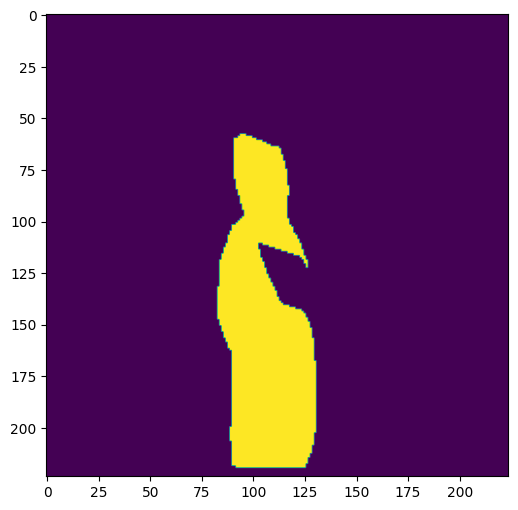

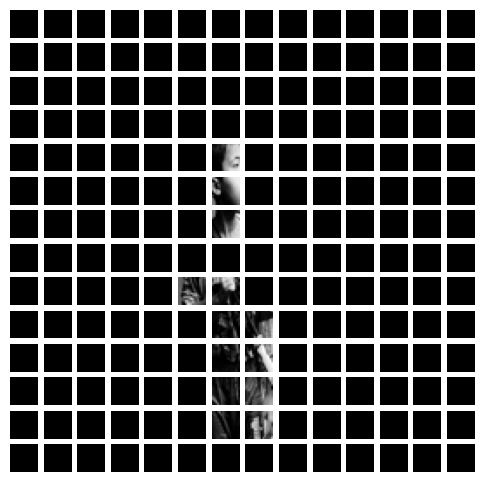

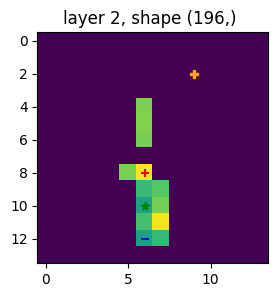

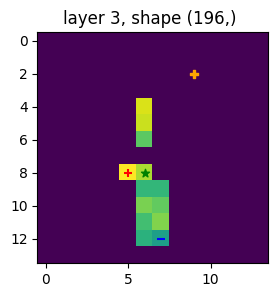

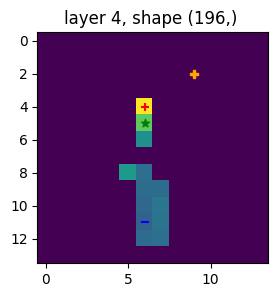

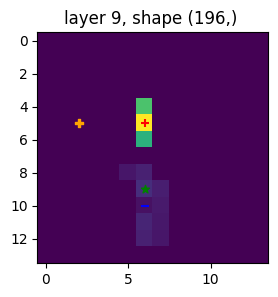

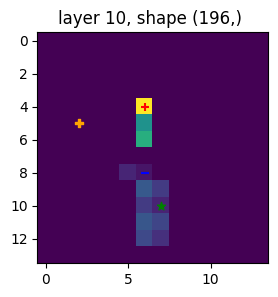

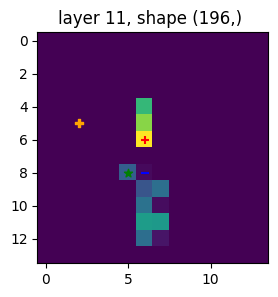

In [80]:
outputs = model.forward_pass(sample_img)
sample_attention_map = model.get_all_attention_maps(outputs.encoder_attentions)
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=4, attention_maps=sample_attention_map)

fg_tokens, cons_fg_token = extract_tokens(img=sample_img.resize((224,224)), 
                                          mask=np.array(masks[0][11].resize((224,224))),
                                          mean_att_map=sample_attention_map,
                                          layers=[2,3,4,9,10,11],
                                          debug=True)

In [81]:
fg_tokens

{2: {'max_image': 37, 'max_obj': 118, 'min_obj': 174, 'random_obj': 146},
 3: {'max_image': 37, 'max_obj': 117, 'min_obj': 175, 'random_obj': 118},
 4: {'max_image': 37, 'max_obj': 62, 'min_obj': 160, 'random_obj': 76},
 9: {'max_image': 72, 'max_obj': 76, 'min_obj': 146, 'random_obj': 132},
 10: {'max_image': 72, 'max_obj': 62, 'min_obj': 118, 'random_obj': 147},
 11: {'max_image': 72, 'max_obj': 90, 'min_obj': 118, 'random_obj': 117}}

In [82]:
# Display tokens
# plt.imshow(mean_att_map[-1,0,1:].cpu().detach().numpy().reshape(grid_size, grid_size))
# col_p = token // grid_size
# row_p = token - (col_p * grid_size)
# plt.scatter(row_p, col_p, marker='*', c='red')

# Extract tokens from datasets

In [83]:
import pandas as pd
from tqdm import tqdm

In [84]:
person_annotations['27'][0].keys()

dict_keys(['annotations', 'image'])

In [85]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
# (1, 27) ('person', 'backpack'): 3524
# (1, 28) ('person', 'umbrella'): 2089
# (1, 31) ('person', 'handbag'): 4890
# (1, 32) ('person', 'tie'): 1543
# (1, 33) ('person', 'suitcase'): 1048
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0, 'umbrella': 1, 'handbag': 2, 'tie': 3, 'suitcase': 4}

In [86]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 
              44: 'bottle', 47: 'cup', 48: 'fork', 49: 'knife', 51: 'bowl', 62: 'chair'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'chair']
# (67, 44) ('dining table', 'bottle'): 1060
# (67, 47) ('dining table', 'cup'): 1919
# (67, 48) ('dining table', 'fork'): 1191
# (67, 49) ('dining table', 'knife'): 1066
# (67, 51) ('dining table', 'bowl'): 1793
# (67, 62) ('dining table', 'chair'): 1898
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0,
 'umbrella': 1,
 'handbag': 2,
 'tie': 3,
 'suitcase': 4,
 'bottle': 5,
 'cup': 6,
 'fork': 7,
 'knife': 8,
 'bowl': 9,
 'chair': 10}

In [87]:
annotation_groups = {67: dining_obj_annotations, 1: person_annotations}
CAPTION_FILTER = False
BATCH_SIZE = 4

In [ ]:
for main_class, annotations_file in annotation_groups.items():
    for second_class, task_annotations in annotations_file.items():
        features = {
    #                 "main_bg_tokens": [],
    #                 "main_consistent_bg_token": [],
                    "main_fg_tokens": [],
                    "main_consistent_fg_token": [],
    #                 "second_bg_tokens": [],
    #                 "second_consistent_bg_token": [],
                    "second_fg_tokens": [],
                    "second_consistent_fg_token": [],
                    "layers_act": [],
                    "class": []}

        print(f"class ({main_class}, {second_class})")
        for idx, ann in enumerate(tqdm(task_annotations)):
            if CAPTION_FILTER and not ann['annotations']['second_object_in_caption']:
                continue
            img = Image.open(os.path.join(COCO_PATH, 'train2017', ann['image']['file_name'])).convert('RGB')    
            outputs = model.forward_pass(img)
            layer_activations = outputs.encoder_hidden_states
            mean_att_map = model.get_all_attention_maps(outputs.encoder_attentions, renorm_weights=True)            
            masks = get_objects_mask(ann, objects=[int(main_class), int(second_class)], option=4, attention_maps=mean_att_map)
            if masks is not None:
                # MAIN OBJECT
                main_fg_tokens, main_cons_fg_token = extract_tokens(img=img.resize((224,224)), 
                                                                    mask=np.array(masks[0][11].resize((224,224))),
                                                                    mean_att_map=mean_att_map,
                                                                    layers=[2,3,4,9,10,11],
                                                                    mask_threshold=.50)
                # SECOND OBJECT
                sec_fg_tokens, sec_cons_fg_token = extract_tokens(img=img.resize((224,224)), 
                                                                  mask=np.array(masks[1][11].resize((224,224))),
                                                                  mean_att_map=mean_att_map,
                                                                  layers=[2,3,4,9,10,11],
                                                                  mask_threshold=.30)
                if main_fg_tokens is not None and sec_fg_tokens is not None:
    #                 features["main_bg_tokens"].append(bg_tokens)
    #                 features["main_consistent_bg_token"].append(cons_bg_token)
                    features["main_fg_tokens"].append(main_fg_tokens)
                    features["main_consistent_fg_token"].append(main_cons_fg_token)
    #                   features["second_bg_tokens"].append(bg_tokens)
    #                 features["second_consistent_bg_token"].append(cons_bg_token)
                    features["second_fg_tokens"].append(sec_fg_tokens)
                    features["second_consistent_fg_token"].append(sec_cons_fg_token)
                    layers_act = [layer_act.cpu().squeeze().detach().numpy() for layer_act in layer_activations]
                    features["layers_act"].append(layers_act)
                    features["class"].append(labels_map[int(second_class)])
    #         else:
    #             print(f"error generating mask for image_id {ann['image']}")

            if len(features["main_fg_tokens"]) >= 1000:            
                break        
        feat_pd = pd.DataFrame(features)
        print(int(second_class), len(feat_pd))
        if len(feat_pd) > 0:
            feat_pd.to_pickle(f"feat_full_act_{labels_map[int(second_class)]}-attn-based.pickle")

class (67, 44)


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1002/1060 [06:34<00:22,  2.54it/s]


44 1001
class (67, 47)


 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 1000/1919 [06:07<05:37,  2.72it/s]


47 1001
class (67, 48)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1006/1191 [05:24<00:59,  3.10it/s]


48 1001
class (67, 49)


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1033/1066 [05:17<00:10,  3.25it/s]


49 1001
class (67, 51)


 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 1000/1793 [05:12<04:07,  3.20it/s]


51 1001
class (67, 62)


 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                      | 1001/1898 [06:37<05:56,  2.52it/s]


62 1001
class (1, 27)


 29%|██████████████████████████████████████████▌                                                                                                          | 1008/3524 [11:23<28:25,  1.48it/s]


27 1001
class (1, 28)


 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 1001/2089 [12:41<13:48,  1.31it/s]


28 1001
class (1, 31)


 18%|██████████████████████████                                                                                                                          | 863/4890 [10:17<1:01:24,  1.09it/s]

In [42]:
print(len(feat_pd))
feat_pd.head()

1001


,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,layers_act,class
0,"{2: {'max_image': 90, 'max_obj': 60, 'min_obj'...",None,"{2: {'max_image': 90, 'max_obj': 87, 'min_obj'...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
1,"{2: {'max_image': 129, 'max_obj': 20, 'min_obj...",None,"{2: {'max_image': 129, 'max_obj': 55, 'min_obj...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
2,"{2: {'max_image': 83, 'max_obj': 104, 'min_obj...",None,"{2: {'max_image': 83, 'max_obj': 93, 'min_obj'...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
3,"{2: {'max_image': 121, 'max_obj': 121, 'min_ob...",None,"{2: {'max_image': 121, 'max_obj': 187, 'min_ob...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
4,"{2: {'max_image': 77, 'max_obj': 120, 'min_obj...",None,"{2: {'max_image': 77, 'max_obj': 82, 'min_obj'...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase


In [90]:
print(len(feat_pd))
feat_pd.head()

299


,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,layers_act,class
0,"[{'max_image': 129, 'max_obj': 20, 'min_obj': ...",None,"[{'max_image': 129, 'max_obj': 55, 'min_obj': ...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
1,"[{'max_image': 159, 'max_obj': 159, 'min_obj':...",None,"[{'max_image': 159, 'max_obj': 166, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
2,"[{'max_image': 136, 'max_obj': 135, 'min_obj':...",None,"[{'max_image': 136, 'max_obj': 136, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
3,"[{'max_image': 69, 'max_obj': 94, 'min_obj': 1...",None,"[{'max_image': 69, 'max_obj': 162, 'min_obj': ...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
4,"[{'max_image': 147, 'max_obj': 117, 'min_obj':...",None,"[{'max_image': 147, 'max_obj': 147, 'min_obj':...",None,"[[[-0.0021190564, 0.014390027, -0.49405986, 0....",suitcase
